In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('fivethirtyeight')
color = '#228cbd'

from sklearn.preprocessing import MinMaxScaler

# Gramian Angular Map 

**Gramian Angular Field** is a technique that allows to map timeseries into a picture.

It consists of three steps:

* **Normalization** - values need to be in range -1, 1.
* Recoding time series to **polar coordinates**
* **Mapping** to a field

## Define util functions

In [2]:
def plot_series(series, title = '', label = ''):
    plt.figure(figsize = (15, 4))
    plt.plot(np.arange(len(series)), series, label = label, alpha = .7, color = color)
    plt.title(title)
    plt.xlabel('Time', color = 'gray')
    plt.ylabel('Value', color = 'gray')
    plt.legend()
    plt.show()

## Generate timeseries

We'll use so called [**logistic map**](https://en.wikipedia.org/wiki/Logistic_map) to produce timeseries with [**chaotic attractor**](https://en.wikipedia.org/wiki/Attractor#Strange_attractor). Logistic map with chaotic attractor is a deterministic model that generates series looking very random.


In [3]:
def logistic_map(initial_size, R, timesteps):
    
    if (initial_size > 1) or (initial_size < 0):
        raise ValueError('Initial size has to be >= 0 and <= 1')
    
    n = initial_size 
    
    vals = [n]
    
    for i in range(timesteps):
        n = R*(n - n**2)
        vals.append(n)
    
    return np.array(vals)

Note that logistic map starts to display chaotic behavior for values of $R > 3.5$

In [4]:
map_R_3_5 = logistic_map(.33, 3.5, 500)

In [5]:
map_R_4 = logistic_map(.33, 4, 500)

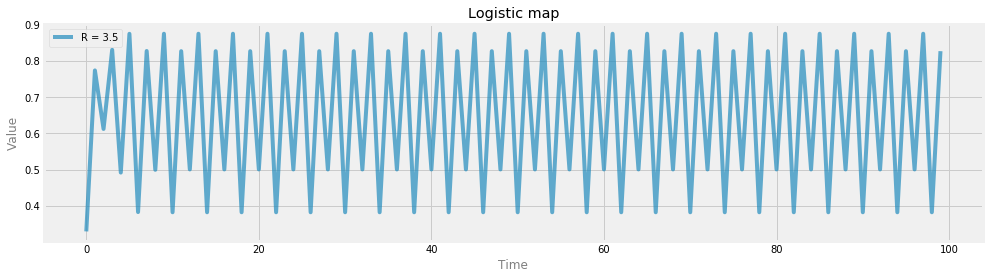

In [6]:
plot_series(map_R_3_5[:100], 'Logistic map', 'R = 3.5')

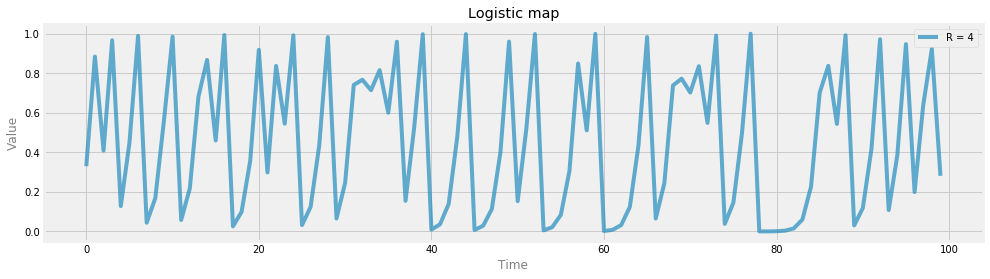

In [7]:
plot_series(map_R_4[:100], 'Logistic map', 'R = 4')

## Step 1: Scale the data

In [10]:
# scaled = MinMaxScaler(feature_range = (-1, 1)).fit_transform(map_R_4.reshape(-1, 1))
series = map_R_4
scaled = (2*series - series.max() - series.min()) / (series.max() - series.min())

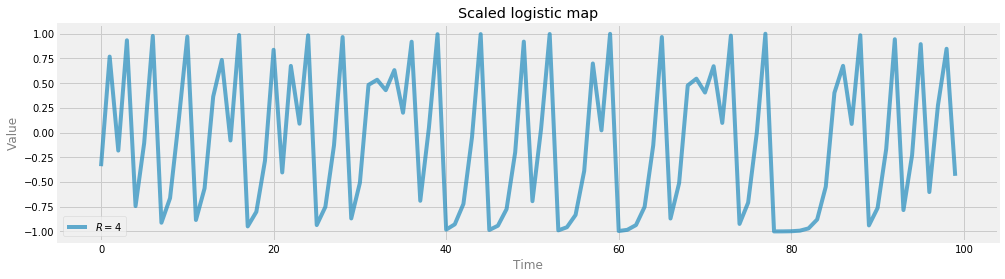

In [11]:
plot_series(scaled[:100], 'Scaled logistic map', '$R = 4$')

In [12]:
# Sanity check
scaled.min(), scaled.max()

(-1.0, 1.0)

In [13]:
# Oooops, some floating imprecision :/
# Values shouldn't be bigger than 1 - let's clip it
scaled = np.clip(scaled, -1, 1)

In [14]:
scaled.min(), scaled.max()

(-1.0, 1.0)

## Step 2: Convert to polar coordinates

To define polar coordinates we'll need two values:
* value of the time series 
* its corresponding timestamp 

They will be expressed respectively as angle and radius.

Angle will be represented as 

$$\large \phi_i = arccos(x_i)$$

Radius as 

$$\large r_i = \frac{i}{N}$$

In [15]:
angles = np.arccos(scaled)

In [16]:
# Sanity check: angles should be in range 0, pi
angles.min(), angles.max() <= np.pi

(0.0, True)

In [17]:
radius = (np.array(range(len(angles)))) / len(angles)

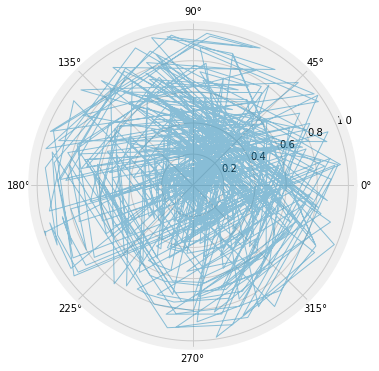

In [34]:
# Let's check it out
plt.figure(figsize = (6, 6))
plt.polar(np.degrees(angles), radius, lw = 1, alpha = .5, color = color)
plt.show()

## Step 3: Build mapping - Gramian Angular Summation Field

There are two GAFs:

* Summation (GASF), represented by $cos(\phi_i + \phi_j)$



* Difference (GADF), represented by $sin(\phi_i - \phi_j)$

For more details check this [paper](https://arxiv.org/pdf/1506.00327.pdf).

In [19]:
def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse = True))

def cos_sum(a, b):
    """To work with tabulate."""
    return(np.cos(a + b))

In [37]:
gasf = tabulate(angles, angles, cos_sum)

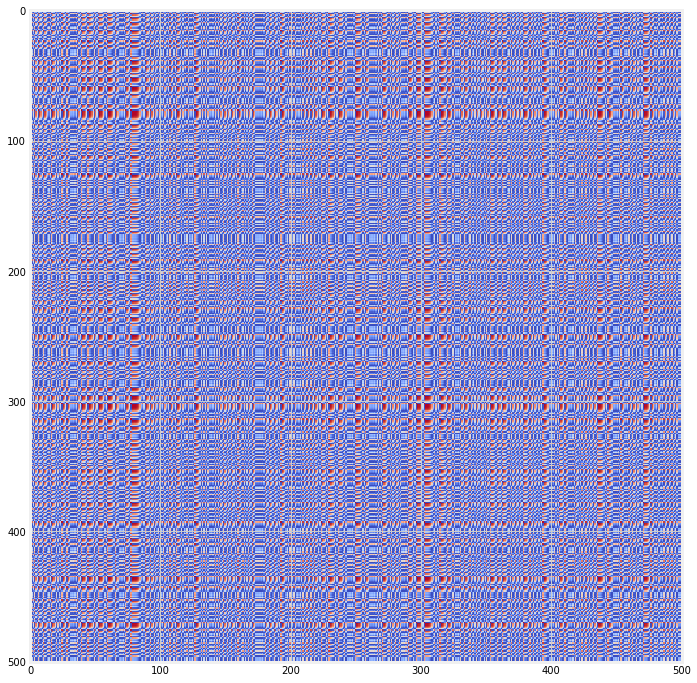

In [38]:
plt.figure(figsize = (12, 12))
plt.imshow(gasf, cmap = 'coolwarm')
plt.show()